# Credit Card Fraud – Autoencoder (custom training loop)

Same idea as before, but this time we train the autoencoder with a manual training loop using `tf.GradientTape` instead of `model.fit`.

In [1]:
!uv pip install -q scikit-learn==1.6.1 imblearn --system

^C


In [ ]:
    %pip uninstall -y scikit-learn imbalanced-learn
    %pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
)

import tensorflow as tf
from tensorflow.keras import layers, models

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

2025-12-06 01:21:51.825122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764984112.046488      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764984112.119259      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ModuleNotFoundError: No module named 'sklearn.utils._metadata_requests'

In [18]:
data_path = "/kaggle/input/creditcardfraud/creditcard.csv"

df = pd.read_csv(data_path)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
if "Time" in df.columns:
    df = df.sort_values("Time").reset_index(drop=True)

X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train = X.iloc[:train_end].values
y_train = y.iloc[:train_end].values

X_val = X.iloc[train_end:val_end].values
y_val = y.iloc[train_end:val_end].values

X_test = X.iloc[val_end:].values
y_test = y.iloc[val_end:].values

In [ ]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("Training Data:")
print(f"Original:: Legitimate: {(y_train == 0).sum():,}, Fraud: {(y_train == 1).sum():,}")
print(f"SMOTE resampled:: Legitimate: {(y_train_smote == 0).sum():,}, Fraud: {(y_train_smote == 1).sum():,}")
print(f"Random undersampling:: Legitimate: {(y_train_rus == 0).sum():,}, Fraud: {(y_train_rus == 1).sum():,}")

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_norm = X_train_scaled[y_train == 0]
X_val_norm = X_val_scaled[y_val == 0]

X_train_norm.shape, X_val_norm.shape

((198980, 30), (42665, 30))

In [21]:
class SimpleAutoencoder(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(input_dim,)),
                layers.Dense(64, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(32, activation="relu"),
                layers.Dense(64, activation="relu"),
                layers.Dense(input_dim, activation="linear"),
            ]
        )

    def call(self, x, training=False):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

input_dim = X_train_norm.shape[1]
model = SimpleAutoencoder(input_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        recon = model(x_batch, training=True)
        loss = loss_fn(x_batch, recon)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

@tf.function
def val_step(x_batch):
    recon = model(x_batch, training=False)
    loss = loss_fn(x_batch, recon)
    return loss

In [23]:
weight_path = "best_autoencoder.weights.h5"

In [24]:
batch_size = 512
max_epochs = 100
patience = 5

train_ds = tf.data.Dataset.from_tensor_slices(X_train_norm).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices(X_val_norm).batch(batch_size)

best_val = np.inf
wait = 0
history = {"loss": [], "val_loss": []}
weight_path = "best_autoencoder.weights.h5"

for epoch in range(1, max_epochs + 1):
    epoch_loss = []
    for xb in train_ds:
        l = train_step(xb)
        epoch_loss.append(float(l))

    val_loss_vals = []
    for xb in val_ds:
        l = val_step(xb)
        val_loss_vals.append(float(l))

    mean_train = float(np.mean(epoch_loss))
    mean_val = float(np.mean(val_loss_vals))

    history["loss"].append(mean_train)
    history["val_loss"].append(mean_val)

    if epoch%10 == 0:
        print(f"epoch {epoch:03d}  loss={mean_train:.6f}  val_loss={mean_val:.6f}")

    if mean_val + 1e-6 < best_val:
        best_val = mean_val
        wait = 0
        model.save_weights(weight_path)
    else:
        wait += 1

    if wait >= patience:
        print("early stopping")
        break

model.load_weights(weight_path)

epoch 010  loss=0.068259  val_loss=0.080836
epoch 020  loss=0.044977  val_loss=0.057857
epoch 030  loss=0.036124  val_loss=0.048408
epoch 040  loss=0.032076  val_loss=0.042893
epoch 050  loss=0.029838  val_loss=0.039268
epoch 060  loss=0.028572  val_loss=0.037360
early stopping


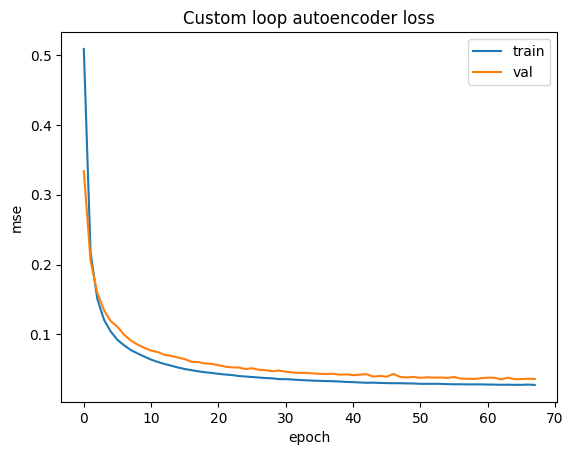

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.title("Custom loop autoencoder loss")
plt.show()

In [26]:
# reconstruction error on validation set
val_recon = model(X_val_scaled, training=False).numpy()
val_mse = np.mean(np.square(X_val_scaled - val_recon), axis=1)

thresholds = np.quantile(val_mse, np.linspace(0.8, 0.995, 50))

best_f1 = -1
best_threshold = None

for t in thresholds:
    y_pred = (val_mse >= t).astype(int)
    tp = ((y_pred == 1) & (y_val == 1)).sum()
    fp = ((y_pred == 1) & (y_val == 0)).sum()
    fn = ((y_pred == 0) & (y_val == 1)).sum()

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

best_threshold, best_f1

(0.6591195975207451, 0.32592592592351166)

In [27]:
test_recon = model(X_test_scaled, training=False).numpy()
test_mse = np.mean(np.square(X_test_scaled - test_recon), axis=1)

test_pred = (test_mse >= best_threshold).astype(int)

print("confusion matrix:")
print(confusion_matrix(y_test, test_pred))
print()
print(classification_report(y_test, test_pred, digits=4))

roc = roc_auc_score(y_test, test_mse)
ap = average_precision_score(y_test, test_mse)

print(f"ROC‑AUC (reconstruction error as score): {roc:.4f}")
print(f"PR‑AUC  (reconstruction error as score): {ap:.4f}")

confusion matrix:
[[42578    92]
 [   13    39]]

              precision    recall  f1-score   support

           0     0.9997    0.9978    0.9988     42670
           1     0.2977    0.7500    0.4262        52

    accuracy                         0.9975     42722
   macro avg     0.6487    0.8739    0.7125     42722
weighted avg     0.9988    0.9975    0.9981     42722

ROC‑AUC (reconstruction error as score): 0.9236
PR‑AUC  (reconstruction error as score): 0.4223


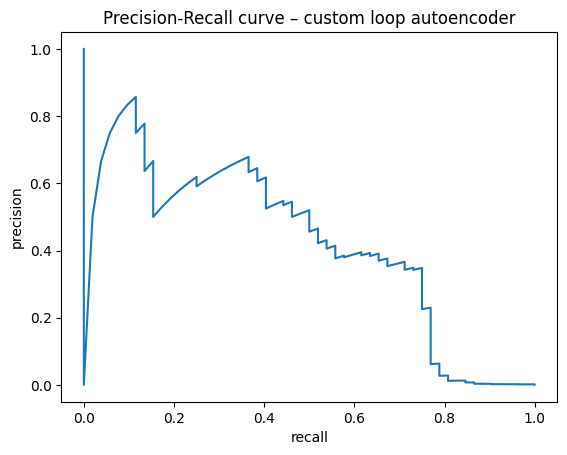

In [28]:
prec, rec, thr = precision_recall_curve(y_test, test_mse)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision‑Recall curve – custom loop autoencoder")
plt.show()